# About the Data

* The data was taken from 
the csv file complaints.csv

* The complaints are for the products:<br>

  1. Banking Services
  2. Card Services
  3. Credit Reporting
  4. Debt Collection
  5. Loans
  6. Mortgage

* The test data with 6000 entries was used to evaluate the model’s performance.

* The macro-averaged f1-score on the test data is 0.87





#Fine Tuning DistilBERT model for text classification

* The model was trained on 5 epochs and the learning rate was set at 1e-5 and batch size 32

* Total time taken to create the dataframe with top 3 rank of predictions in the test data is : 0:36:05 (h:mm:ss)

 Data Split:<br>
      -Training data: 48000 (80 percent)
      -Validation data: 6000 (10 percent)
      -Test Data :  6000 (10 percent)


* Macro-averaged f1-score<br>
      -Training data: 0.89
      -Validation data: 0.85
      -Testing data: 0.87 

* Fine-tuning was done on the sample data of 60000 entries


##Memory Allocated

In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

13G


##Google Drive access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Path

In [ ]:
# write the appropriate paths to retrieve the data and store results 
saved_path = '/content/drive/MyDrive/EY_Internship/Consumer_Complaints/'
used_test_data_path = saved_path  + "Test_data_DistilBERT.csv"

## Set-up environment

Install the libraries HuggingFace Transformers and Datasets

In [ ]:
#Install HuggingFace tranformer and datasets libraries  
!pip install folium==0.2.1 -q
!pip install -q transformers datasets 

     |████████████████████████████████| 69 kB 3.5 MB/s 
     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 342 kB 41.6 MB/s 
     |████████████████████████████████| 596 kB 47.7 MB/s 
     |████████████████████████████████| 6.6 MB 52.3 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 212 kB 69.9 MB/s 
     |████████████████████████████████| 1.1 MB 48.5 MB/s 
     |████████████████████████████████| 136 kB 61.2 MB/s 
     |████████████████████████████████| 127 kB 58.5 MB/s 
     |████████████████████████████████| 144 kB 58.9 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 271 kB 60.5 MB/s 


In [ ]:
#Check if GPU is available
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device, "is available")

cpu is available


## Loading the Dataset

In [ ]:
#Load the data
import pandas as pd
test_data_df = pd.read_csv(used_test_data_path)
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  6000 non-null   object
 1   label     6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


Example

In [ ]:
test_data_df.loc[0,'sentence']

'and experian have violated my rights by reporting this incorrect account that dont belong on my credit report i have written these companies times and i havent seen or received any updates this is unfair that i have to deal with this matter and they wont resolve this issue'

In [ ]:
test_data_df.loc[0,'label']

'Credit Reporting'

In [ ]:
#Import the librarires required for the function get_top3_rank
import torch
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import logging
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW 
from transformers import pipeline
import numpy as np
import time

In [ ]:
#Create a function for formatting elapsed times as hh:mm:ss
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def get_top3_rank(df,column_name):
  """
  df: the input dataframe containg text
  column_name : the text column containg the input text
  the function get_top3_rank outputs rank_df the dataframe that contains the top 3 ranks
  """
  ############################################################################################################
  #Function to create DistilBERT pipeline
  ############################################################################################################
  def get_rank_dataframe(df,column_name):
    """
    df: the input dataframe containg text
    column_name : the text column containg the input text
    the function get_rank_dataframe returns the dataframe with top3 ranks
    """
    ############################################################################################################
    #Check if GPU is Available or not
    ############################################################################################################
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    ############################################################################################################
    #Write the appropriate paths to retrieve the data 
    ############################################################################################################
    user_path = '/content/drive/MyDrive/EY_Internship/Consumer_Complaints/'
    best_model_path = user_path + "best_model.pt"
    label2id_df_path = user_path + "label2id_df.csv"
    ############################################################################################################
    #Create a label2id dictionary to map label and index
    ############################################################################################################
    labels2id_df = pd.read_csv(label2id_df_path)
    labels = labels2id_df.columns.to_list()
    ids = [int(i) for i in labels2id_df.loc[0,:]]
    id2label = {A: B for A, B in zip(ids, labels)} 
    label2id = {A: B for A, B in zip(labels,ids)} 
    labels = list(labels)
    ############################################################################################################
    #Load the tokenizer
    ############################################################################################################
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased',num_labels=len(labels))
    logging.set_verbosity_error()
    ############################################################################################################
    #Load the best model
    ############################################################################################################
    model_best = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)


    model_best.to(device)
    ############################################################################################################
    #SET THE PARAMETERS
    fixed_learning_rate = 1e-5
    fixed_batch_size = 32
    ############################################################################################################
    #LOAD THE OPTIMZER
    #Optimizer
    optimizer_learning_rate = 1e-5
    optimizer_adam_epsilon = 1e-8

    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model_best.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.2},
        {'params': [p for n, p in model_best.named_parameters() if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]

    optimizer_best = AdamW(optimizer_grouped_parameters, lr = optimizer_learning_rate, eps=optimizer_adam_epsilon)
    ############################################################################################################
    # The function load_chkp is created for loading model
    def load_ckp(checkpoint_fpath, model, optimizer):
      """
      checkpoint_path: path to save checkpoint
      model: model that we want to load checkpoint parameters into       
      optimizer: optimizer we defined in previous training
      """
      # load check point
      checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
      # initialize state_dict from checkpoint to model
      model.load_state_dict(checkpoint['state_dict'])
      # initialize optimizer from checkpoint to optimizer
      optimizer.load_state_dict(checkpoint['optimizer'])
      # initialize valid_loss_min from checkpoint to valid_loss_min
      valid_loss_min = checkpoint['valid_loss_min']
      # return model, optimizer, epoch value, min validation loss 
      return model, optimizer, checkpoint['epoch'], valid_loss_min

    # load the saved checkpoint
    model_best, optimizer_best, end_epoch, valid_loss_min = load_ckp(best_model_path, model_best, optimizer_best)
    ############################################################################################################
    #Get inference from the DistilBERT pipline
    ############################################################################################################  
    #set the device_value
    if device == 'cuda:0':
        device_value = 0
    else:
        device_value =-1

     #Create the DistilBERT pipeline
    MAX_LENGTH = model_best.config.max_position_embeddings
  
    distilbert_nlp = pipeline(task="sentiment-analysis", return_all_scores = True, model=model_best, tokenizer=tokenizer,
                              device= device_value, max_length = MAX_LENGTH , truncation=True)
    ############################################################################################################
    #Return the result in a data frame
    ############################################################################################################
    labels_rank_list=[]
    labels_score_list=[]
    def get_rank(example,fix_rank = 3):
      result_value = distilbert_nlp(example)
      sorted_value = sorted(result_value[0], key=lambda k: k['score'],reverse = True)
      new_dictionary_label = {'predicted_label_' + str(i+1): sorted_value[i]['label'] for i in range(fix_rank)}
      new_dictionary_score = {'predicted_percentage_' + str(i+1): 100 * sorted_value[i]['score'] for i in range(fix_rank)}
      labels_rank_list.append(new_dictionary_label)
      labels_score_list.append(new_dictionary_score)
    df[column_name].map(lambda row : get_rank(row,fix_rank = 3))
    list2d_rank = {key: [i[key] for i in labels_rank_list] for key in labels_rank_list[0]}
    list2d_score = {key: [i[key] for i in labels_score_list] for key in labels_score_list[0]}
    predicted_dataframe = pd.concat([df,pd.DataFrame(list2d_rank),pd.DataFrame(list2d_score)], axis=1)
    predicted_dataframe.rename(columns = {'label':'true_label'}, inplace = True)
    return predicted_dataframe
  start_t0 = time.time()
  rank_df = get_rank_dataframe(df,column_name)
  print("\nTotal time taken to create the dataframe: {:} (h:mm:ss)".format(format_time(time.time() - start_t0)))
  return rank_df

In [ ]:
#Call the function get_top3_rank using the input test_data_df and 'sentence' column in test_data_df to return the dataframe with top 3 rank
top3_df = get_top3_rank(test_data_df,'sentence')


Total time taken to create the dataframe: 0:36:05 (h:mm:ss)


In [ ]:
#Display the first five entries in the data frame top3_df
top3_df.head()

,sentence,true_label,predicted_label_1,predicted_label_2,predicted_label_3,predicted_percentage_1,predicted_percentage_2,predicted_percentage_3
0,and experian have violated my rights by report...,Credit Reporting,Credit Reporting,Debt Collection,Loans,97.940391,1.448661,0.223262
1,on i received an email alert from bank of amer...,Banking Services,Mortgage,Banking Services,Card Services,49.463087,48.559922,0.569510
2,i took out some private student loans from cha...,Loans,Loans,Debt Collection,Banking Services,98.891115,0.613996,0.184167
3,i had my card data stolen and reported the fra...,Card Services,Card Services,Banking Services,Debt Collection,97.770691,1.216126,0.535340
4,my car got repossessed on and ive bin having i...,Loans,Loans,Banking Services,Credit Reporting,65.664756,18.247461,9.622851


Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [ ]:
labels2id_df = pd.read_csv(label2id_df_path)
labels2id_df

,Banking Services,Card Services,Credit Reporting,Debt Collection,Loans,Mortgage
0,0,1,2,3,4,5


In [ ]:
labels = labels2id_df.columns.to_list()
ids = [int(i) for i in labels2id_df.loc[0,:]]
id2label = {A: B for A, B in zip(ids, labels)} 
label2id = {A: B for A, B in zip(labels,ids)} 
labels = list(labels)

The dataset consists of 6 labels.

The confusion matrix is : 



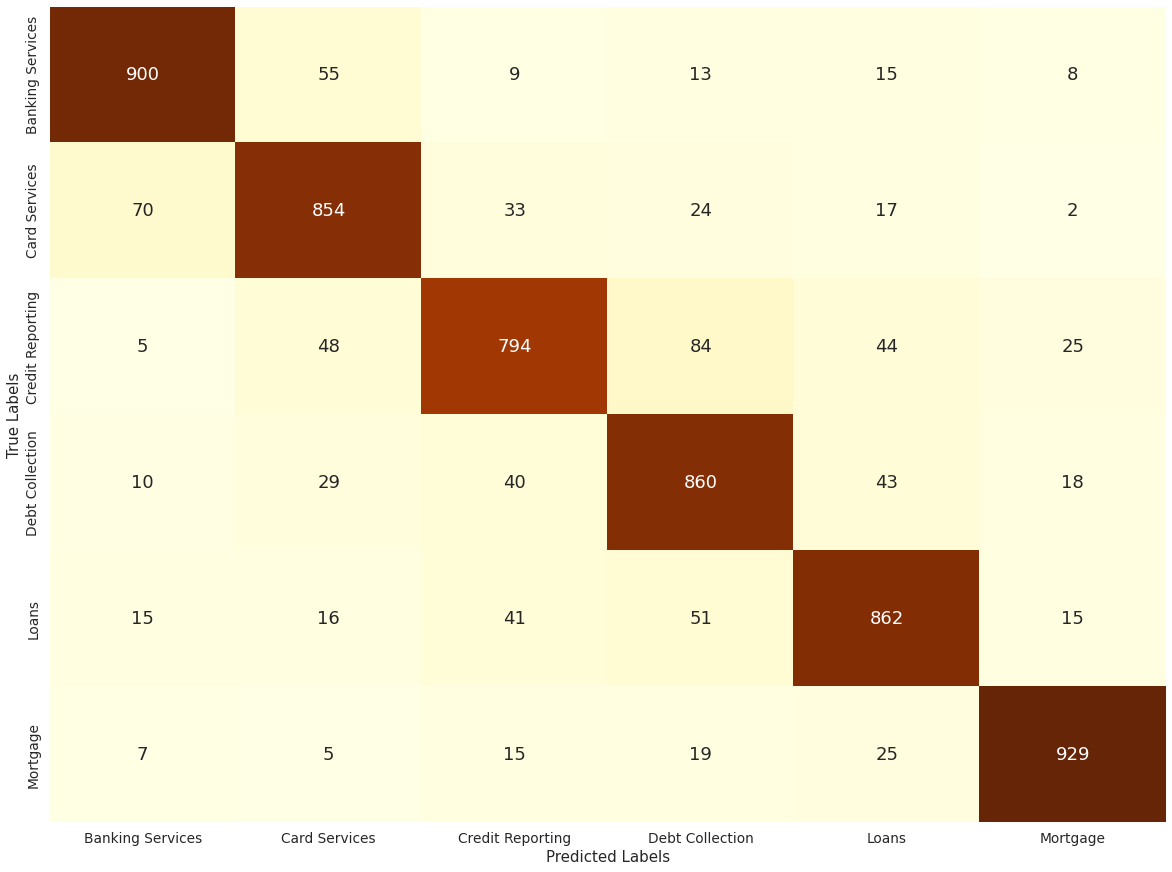

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
True_labels = top3_df["true_label"].to_list() 
Predicted_labels = top3_df["predicted_label_1"].to_list() 
cm = confusion_matrix(True_labels, Predicted_labels)
#plot the confusion matrix
print("The confusion matrix is : \n")
plt.figure(figsize=(20,15))
sns.set(font_scale=1.25)
ax =sns.heatmap(cm, annot=True, fmt='d',cbar=False,xticklabels=labels, yticklabels=labels,cmap="YlOrBr",annot_kws={"size": 18})
ax.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.show()

In [ ]:
#Display Classification Report
from sklearn.metrics import classification_report
print(classification_report(True_labels, Predicted_labels,zero_division=0))

                  precision    recall  f1-score   support

Banking Services       0.89      0.90      0.90      1000
   Card Services       0.85      0.85      0.85      1000
Credit Reporting       0.85      0.79      0.82      1000
 Debt Collection       0.82      0.86      0.84      1000
           Loans       0.86      0.86      0.86      1000
        Mortgage       0.93      0.93      0.93      1000

        accuracy                           0.87      6000
       macro avg       0.87      0.87      0.87      6000
    weighted avg       0.87      0.87      0.87      6000



In [ ]:
# Calculate the First Prediction Percentages
top3_df["First_Prediction_Percentage"] = (top3_df["true_label"]  == top3_df['predicted_label_1']) * 100
# Calculate the First and Second Prediction Percentages
top3_df["First_and_Second_Prediction_Percentage"] = ((top3_df["true_label"]  == top3_df['predicted_label_1']) |((top3_df["true_label"]  == top3_df['predicted_label_2']))) * 100

In [ ]:
# Calculate the accuracy of First and Second Predictions
accuracy_df = top3_df.loc[:,['true_label',"First_Prediction_Percentage", "First_and_Second_Prediction_Percentage"]].groupby('true_label').mean() 
accuracy_df 

,First_Prediction_Percentage,First_and_Second_Prediction_Percentage
true_label,,
Banking Services,90.0,97.0
Card Services,85.4,95.9
Credit Reporting,79.4,95.2
Debt Collection,86.0,95.8
Loans,86.2,95.3
Mortgage,92.9,95.7
